In [2]:
%cd ..

C:\Users\eakos\Рабочий стол\FIIT\ZNEUS\Project1_zneus_Bioresponse


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import warnings
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold


dataset_path = "./data/phpSSK7iA.csv"

df = pd.read_csv(dataset_path, sep=",")

df.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776,target
0,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,0.243144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,0.106480,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,0.352308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,0.208989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,0.125177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
df.shape

(3751, 1777)

In [5]:
duplicates = df.duplicated()
len(df[duplicates])

0

In [6]:
print(df.isnull().sum().sum())

0


In [7]:
zero_cols = [c for c in df.columns if df[c].notna().all() and (df[c] == 0).all()]

df.drop(columns=zero_cols, inplace=True)

In [8]:
const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
df.drop(columns=const_cols, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, D1 to target
dtypes: float64(1776), int64(1)
memory usage: 50.9 MB


In [10]:
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols_all if c != 'target']

variance = df[num_cols].var()
print(f"Low variance features (<0.01): {(variance < 0.01).sum()}")

num_of_norm = 0
num_of_not_norm = 0
skipped = 0

for col in num_cols:
    series = df[col].dropna()
    if series.nunique() <= 1:
        skipped += 1
        continue
    sample = series.sample(n=min(5000, len(series)), random_state=42)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            stat, p_value = shapiro(sample)
        except Exception:
            skipped += 1
            continue
    if p_value >= 0.01:
        num_of_norm += 1
    else:
        num_of_not_norm += 1

print(f"Skipped (constant / error): {skipped}")
print(f"Number of features with normality: {num_of_norm}")
print(f"Number of features without normality: {num_of_not_norm}")

Low variance features (<0.01): 839
Skipped (constant / error): 0
Number of features with normality: 0
Number of features without normality: 1776


TARGET ANALYSIS

target
1    2034
0    1717
Name: count, dtype: int64
target
1    0.542255
0    0.457745
Name: proportion, dtype: float64


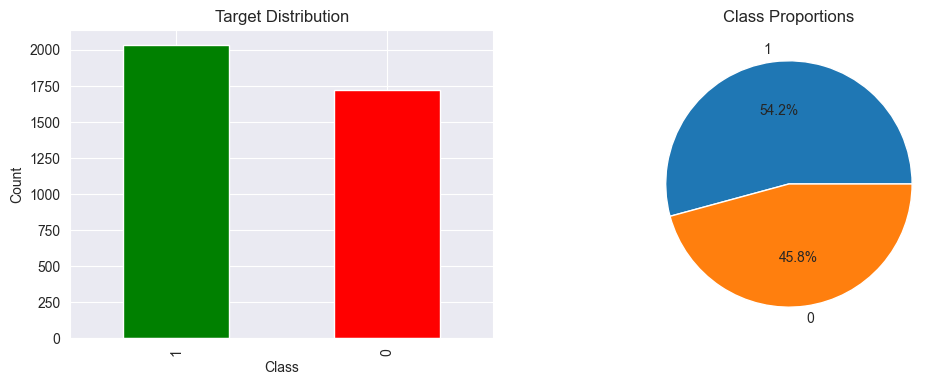

Class imbalance ratio: 0.84


In [11]:
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['target'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Target Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

df['target'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Class Proportions')
axes[1].set_ylabel('')
plt.show()


class_ratio = df['target'].value_counts(normalize=True)
print(f"Class imbalance ratio: {class_ratio[0]/class_ratio[1]:.2f}")

if abs(class_ratio[0] - 0.5) > 0.1:
    print("Classes are imbalanced")

BIVARIATE ANALYSIS

Top 20 features by correlation with target:
D27      0.472340
D469     0.268601
D217     0.233387
D182     0.228664
D747     0.226468
D659     0.226049
D87      0.223081
D146     0.213311
D607     0.210270
D209     0.210154
D660     0.204864
D596     0.204092
D595     0.198737
D187     0.198590
D979     0.198301
D158     0.197721
D1036    0.193792
D1087    0.190054
D83      0.184945
D60      0.180185
dtype: float64


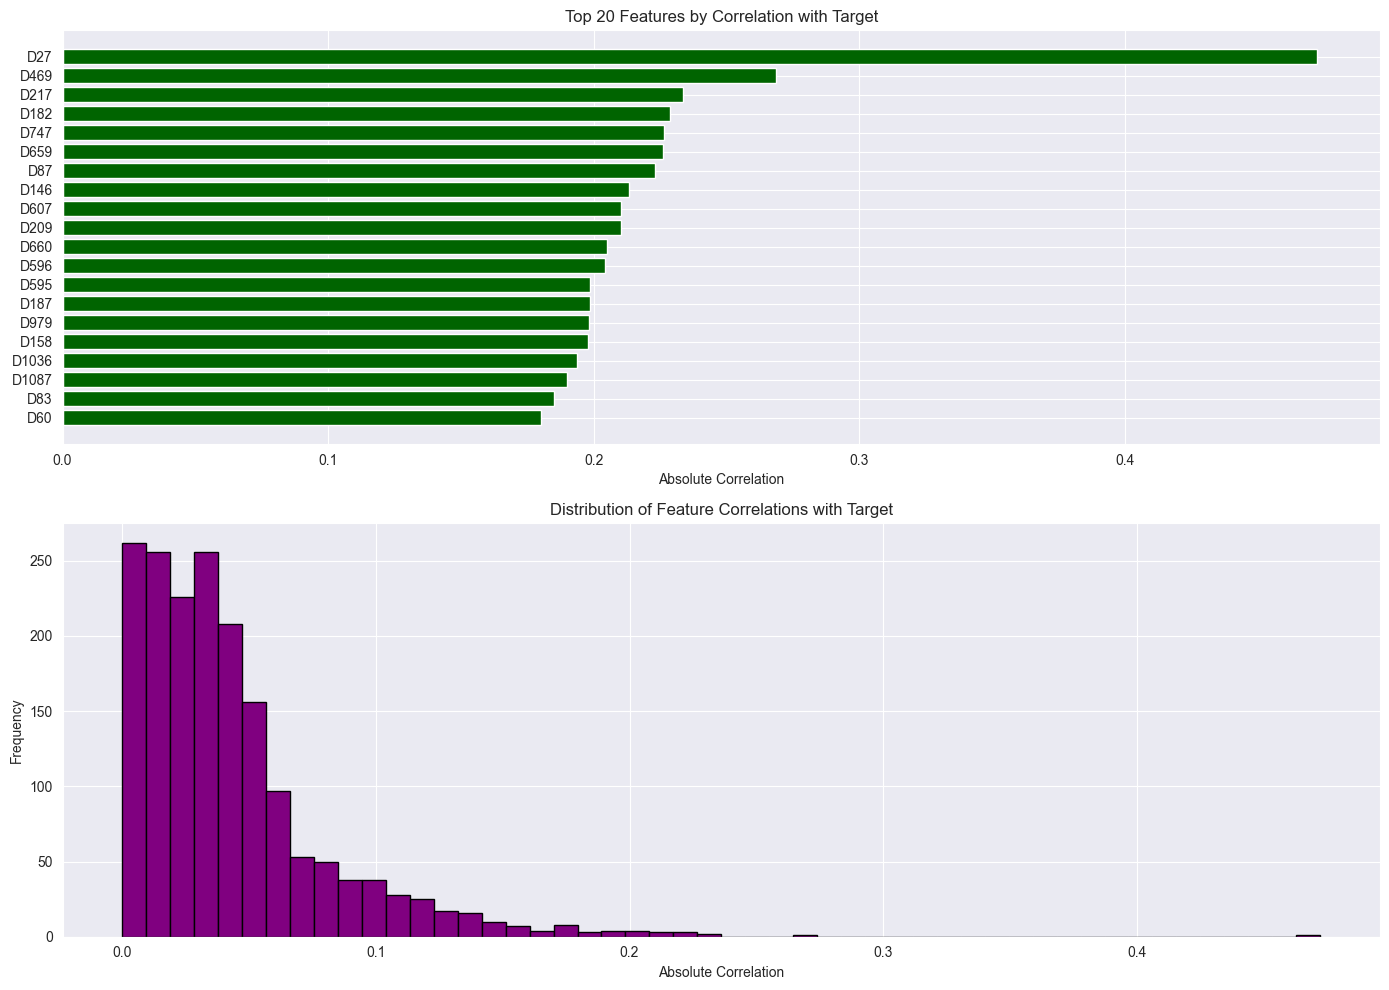

In [12]:
features = [col for col in df.columns if col != 'target']
correlations = df[features].corrwith(df['target']).abs()
correlations = correlations.sort_values(ascending=False)

print("Top 20 features by correlation with target:")
print(correlations.head(20))

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

top_20 = correlations.head(20)
axes[0].barh(range(len(top_20)), top_20.values, color='darkgreen')
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20.index)
axes[0].set_xlabel('Absolute Correlation')
axes[0].set_title('Top 20 Features by Correlation with Target')
axes[0].invert_yaxis()

axes[1].hist(correlations, bins=50, edgecolor='black', color='purple')
axes[1].set_xlabel('Absolute Correlation')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Feature Correlations with Target')
plt.tight_layout()
plt.show()

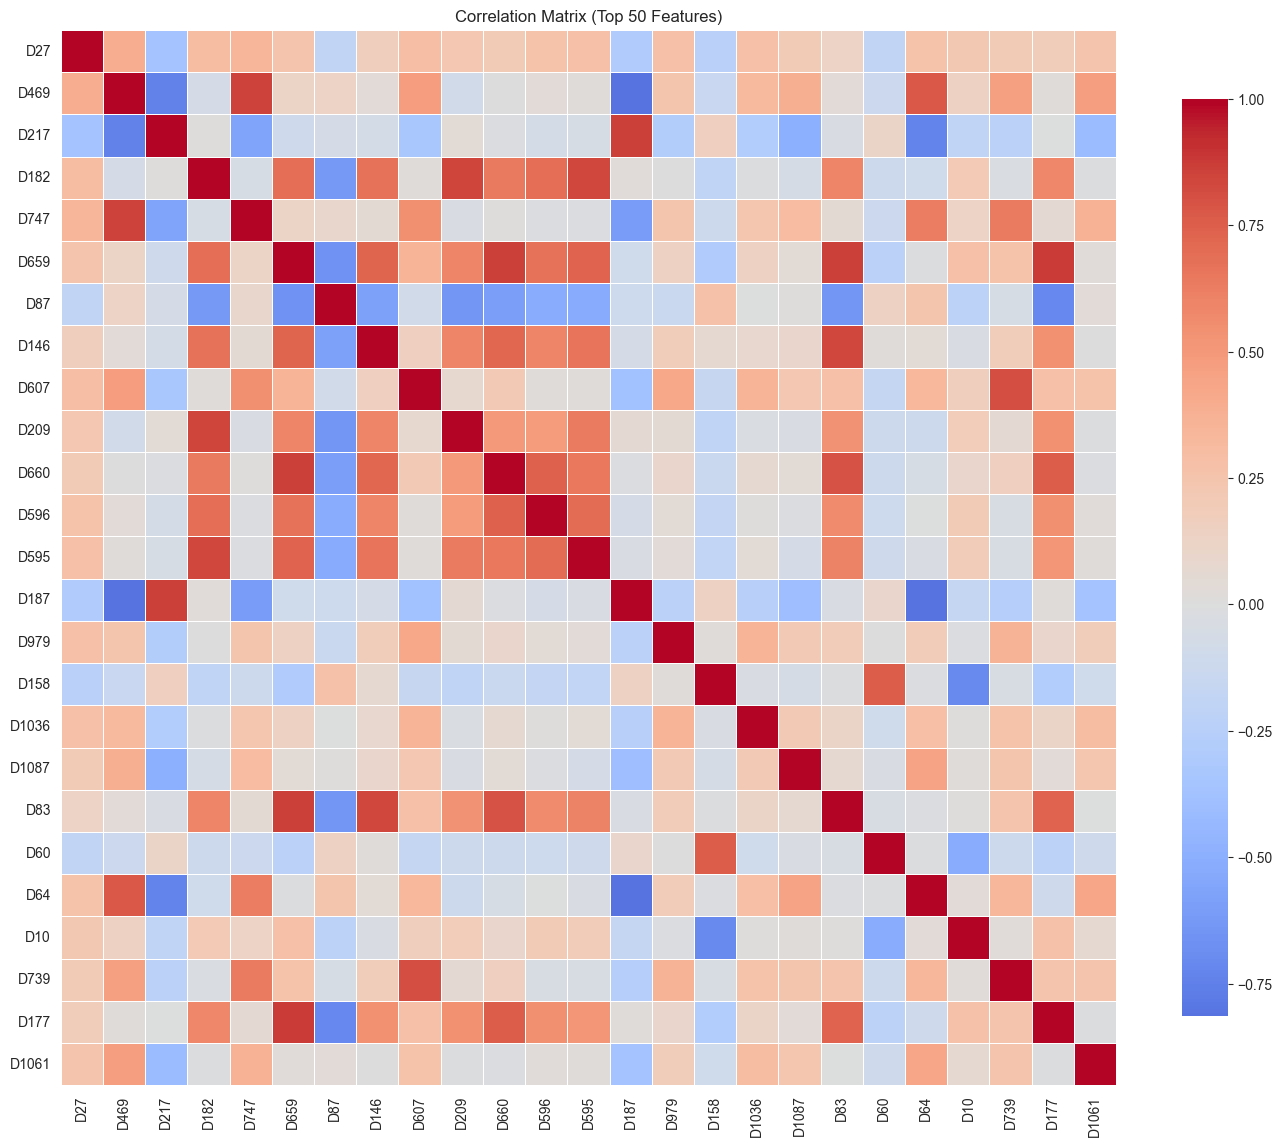

Pairs with correlation > 0.8: 11
D659 - D177: 0.8762
D659 - D83: 0.8610
D659 - D660: 0.8595
D217 - D187: 0.8583
D469 - D747: 0.8526
D182 - D209: 0.8490
D182 - D595: 0.8431
D146 - D83: 0.8335
D469 - D187: -0.8148
D187 - D64: -0.8123
Components for 95% variance: 516
Components for 99% variance: 871


In [16]:
top_25_features = correlations.head(25).index
corr_matrix = df[top_25_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (Top 50 Features)')
plt.tight_layout()
plt.show()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

print(f"Pairs with correlation > 0.8: {len(high_corr_pairs)}")
for pair in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.4f}")

scaler = StandardScaler()
X = df.drop('target', axis=1)
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
n_comp_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_comp_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"Components for 95% variance: {n_comp_95}")
print(f"Components for 99% variance: {n_comp_99}")


OUTLIER DETECTION

Features with outliers:
1776
Features with most outliers (Z-score > 3):
     feature  n_outliers
1267   D1268         372
1322   D1323         370
1255   D1256         368
1348   D1349         366
1228   D1229         361
1431   D1432         360
1230   D1231         359
1315   D1316         359
1390   D1391         355
1385   D1386         354


Outliers IQR: 1776
Features with most outliers (IQR method):
D949     1549
D178     1167
D205     1167
D516      932
D445      930
D1030     929
D1337     920
D1101     910
D1060     907
D1019     907
dtype: int64


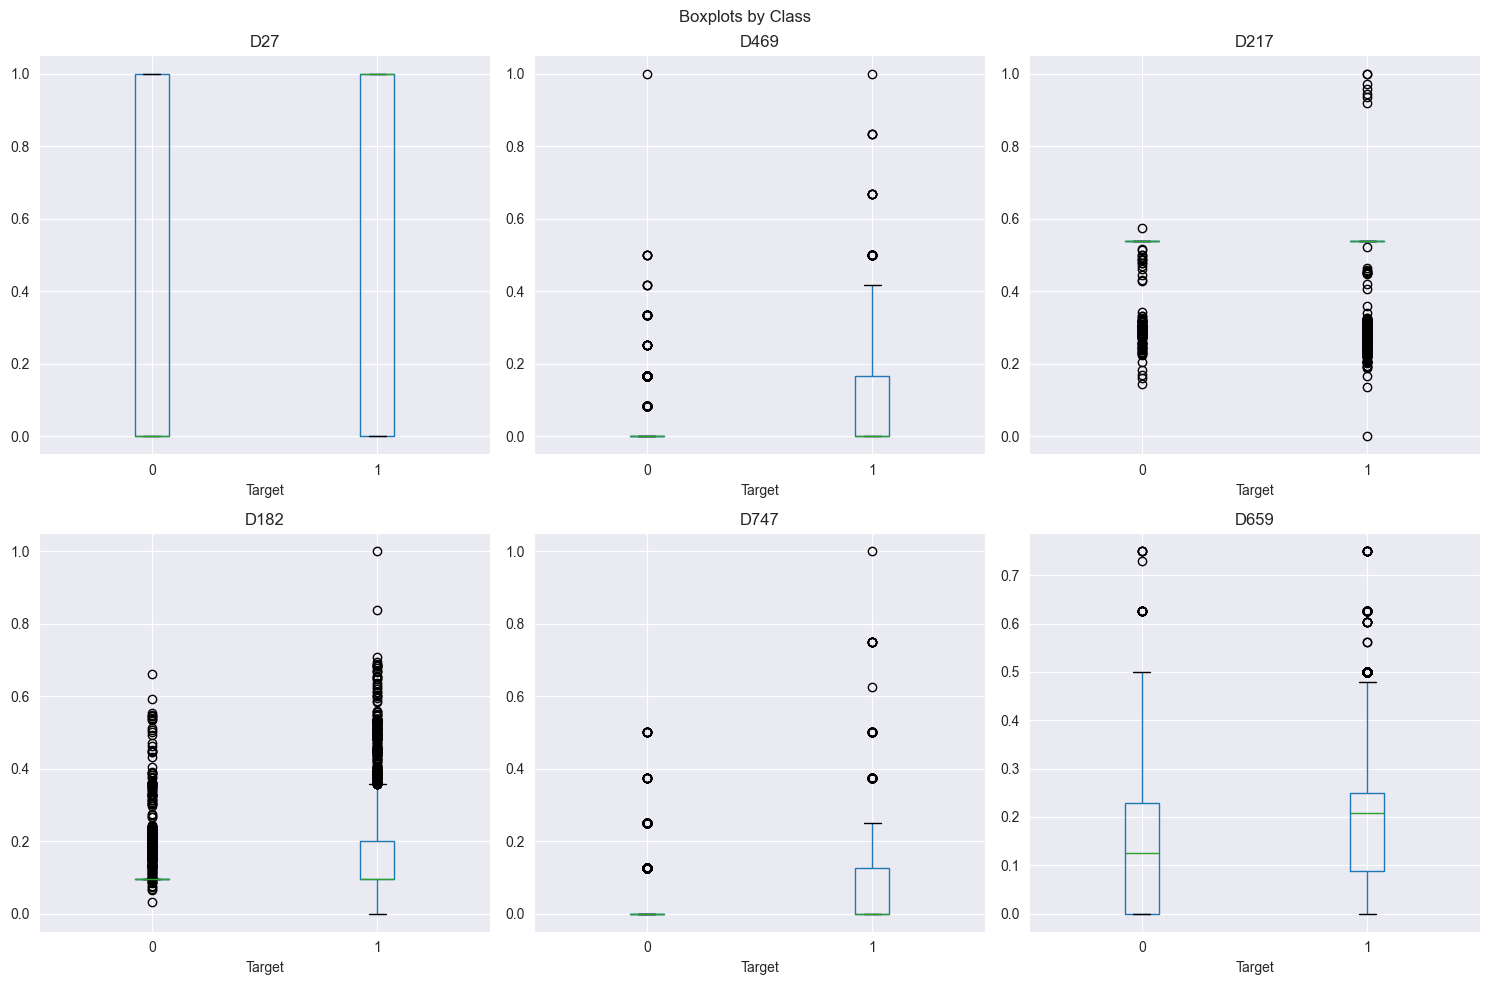


Multivariate outliers detected: 375 (10.00%)


In [14]:
X = df.drop('target', axis=1)
z_scores = np.abs(stats.zscore(X))
outliers = (z_scores > 3).sum(axis=0)

print(f"Features with outliers:\n{len(outliers)}")
print("Features with most outliers (Z-score > 3):")
outlier_df = pd.DataFrame({
    'feature': X.columns,
    'n_outliers': outliers
}).sort_values('n_outliers', ascending=False)
print(outlier_df.head(10))

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).sum()

print(f"\n\nOutliers IQR: {len(outliers_iqr)}")
print("Features with most outliers (IQR method):")
print(outliers_iqr.sort_values(ascending=False).head(10))

top_6_features = correlations.head(6).index
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, (ax, feature) in enumerate(zip(axes.flat, top_6_features)):
    df.boxplot(column=feature, by='target', ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('Target')
plt.suptitle('Boxplots by Class')
plt.tight_layout()
plt.show()

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso_forest.fit_predict(X_scaled)
n_outliers = (outlier_labels == -1).sum()
print(f"\nMultivariate outliers detected: {n_outliers} ({n_outliers/len(X)*100:.2f}%)")

Features after variance threshold: 937


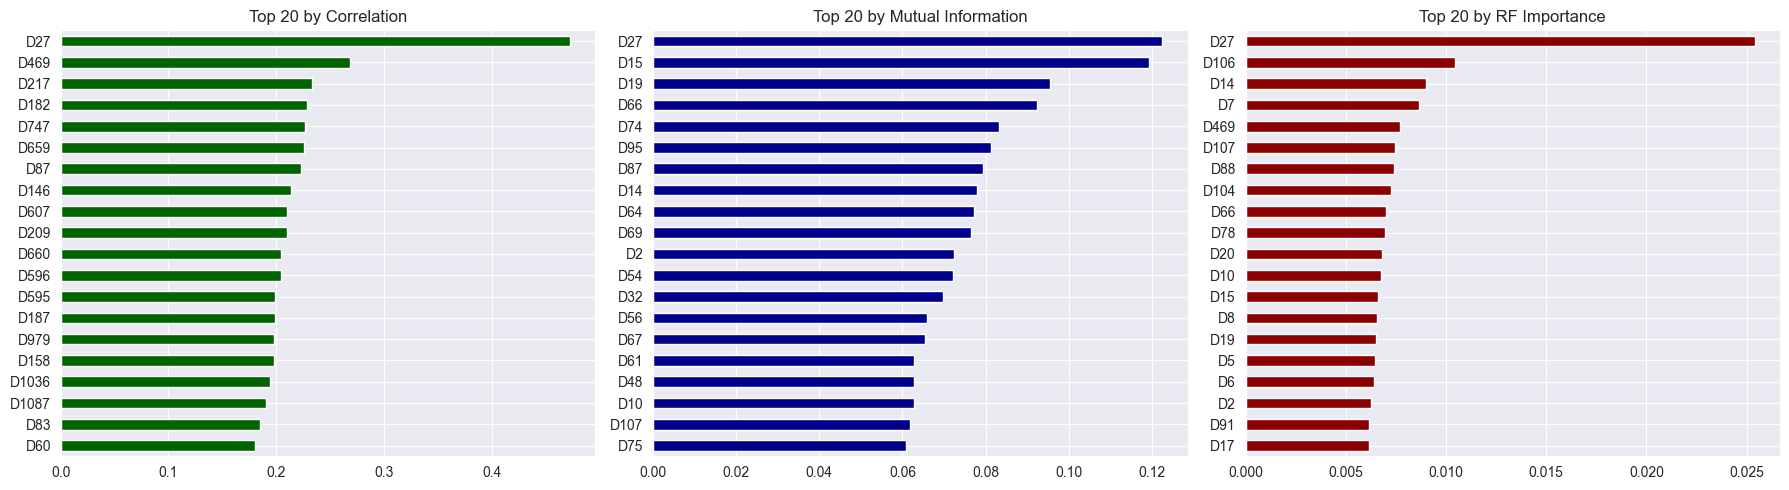


Features in top-100 of all 3 methods: 38


In [15]:
selector = VarianceThreshold(threshold=0.01)
X_high_var = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()].tolist()
print(f"Features after variance threshold: {len(selected_features)}")

mi_scores = mutual_info_classif(X, df['target'], random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, df['target'])
feature_importance = pd.Series(rf.feature_importances_,
                               index=X.columns).sort_values(ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

correlations.head(20).plot(kind='barh', ax=axes[0], color='darkgreen')
axes[0].set_title('Top 20 by Correlation')
axes[0].invert_yaxis()

mi_scores.head(20).plot(kind='barh', ax=axes[1], color='darkblue')
axes[1].set_title('Top 20 by Mutual Information')
axes[1].invert_yaxis()

feature_importance.head(20).plot(kind='barh', ax=axes[2], color='darkred')
axes[2].set_title('Top 20 by RF Importance')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

comparison = pd.DataFrame({
    'correlation': correlations,
    'mutual_info': mi_scores,
    'rf_importance': feature_importance
})

top_by_corr = set(correlations.head(100).index)
top_by_mi = set(mi_scores.head(100).index)
top_by_rf = set(feature_importance.head(100).index)

common_top = top_by_corr & top_by_mi & top_by_rf
print(f"\nFeatures in top-100 of all 3 methods: {len(common_top)}")